In [1]:
#####
# AUTHOR: Neha Abhyankar
# FILENAME: main.py
# SPECIFICATION: LSTM, BI-LSTM and Dense deep learning model implementation for SPAM detection
# Comparison with traditional Naive Bayes
# FOR: CS 5331 Machine Learning and Information Security
#####

In [78]:
import tensorflow as tf
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn import naive_bayes, metrics, feature_extraction
from sklearn.metrics import classification_report
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GlobalAveragePooling1D,  Flatten, Dense, Dropout, LSTM, SpatialDropout1D, Bidirectional

In [70]:
# Reading and Displaying Data
messages = pd.read_csv('spam_ham_dataset.csv')
messages

,label,message
0,ham,"Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there g..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive ...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives around here though"
...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u. U have won the £750 Pound prize. 2 claim is easy...
5568,ham,Will ü b going to esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other suggestions?"
5570,ham,The guy did some bitching but I acted like i'd be interested in buying something else next week ...


In [71]:
messages.groupby('label').describe().T

label                              ham                                                                                                 spam
message count                     4825                                                                                                  747
        unique                    4516                                                                                                  653
        top     Sorry, I'll call later  Please call our customer service representative on FREEPHONE 0808 145 4742 between 9am-11pm as y...
        freq                        30                                                                                                    4

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'Distribution of ham and spam email messages')

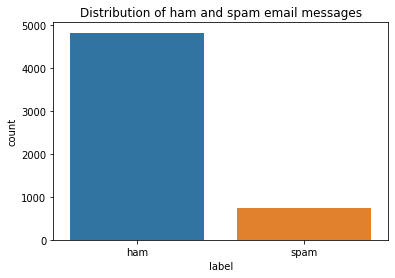

In [72]:
# Getting Spam and Ham messages in different dataframes
ham_msg = messages[messages.label =='ham']
spam_msg = messages[messages.label=='spam']
# Observing classes distribution
plt.figure(figsize=(6,4))
sns.countplot(messages.label)
plt.title('Distribution of ham and spam email messages')

In [73]:
# Fixing imbalance by downsampling
new_ham_msg = ham_msg.sample(n = len(spam_msg), random_state = 44)
new_spam_msg = spam_msg
# Combining data
new_msg = new_ham_msg.append(new_spam_msg).reset_index(drop=True);
f = feature_extraction.text.CountVectorizer(stop_words = 'english')
X = f.fit_transform(new_msg["message"])

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 0, 'Message types')

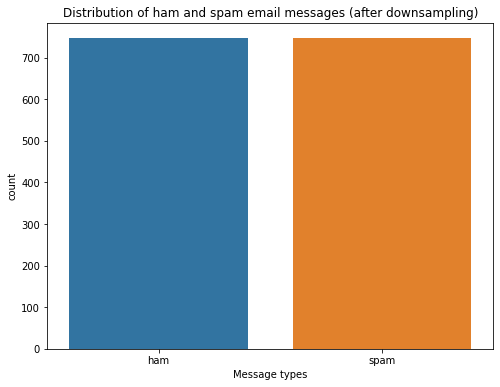

In [74]:
plt.figure(figsize=(8,6))
sns.countplot(new_msg.label)
plt.title('Distribution of ham and spam email messages (after downsampling)')
plt.xlabel('Message types')

In [75]:
# Get length column for each text
new_msg['text_length'] = new_msg['message'].apply(len)

#Calculate average length by label types
labels = new_msg.groupby('label').mean()
print(labels)
# Displaying longest length message
lengths = new_msg["message"].str.len()
argmax = np.where(lengths == lengths.max())[0]
new_msg.iloc[argmax]

       text_length
label             
ham      73.238286
spam    138.670683


,label,message,text_length
610,ham,For me the love should start with attraction.i should feel that I need her every time around me....,910


In [76]:
# Mapping Ham and Spam to numeric classes 0 and 1
new_msg['msg_type']= new_msg['label'].map({'ham': 0, 'spam': 1})
msg_label = new_msg['msg_type'].values

In [49]:
# Split data into train and test size 70:30
train_msg, test_msg, train_labels, test_labels = train_test_split(new_msg['message'], msg_label, test_size=0.2, random_state=434)
train_msg1, test_msg1, train_labels1, test_labels1 = train_test_split(X, msg_label, test_size=0.2, random_state=434)

In [17]:
# Defining pre-processing hyperparameters for tokenization
max_len = 50 # pad_sequencs parameter, it idicates we are only going to look for 50 words in a sentence
trunc_type = "post" # pad_sequences parameter
padding_type = "post" # pad_sequences parameter
oov_tok = "<OOV>" # out of vocabulary token
vocab_size = 500

In [18]:
tokenizer = Tokenizer(num_words = vocab_size, char_level=False, oov_token = oov_tok)
tokenizer.fit_on_texts(train_msg)

In [20]:
# word_index contains the unique words of dataset
word_index = tokenizer.word_index


In [21]:
# Sequencing and padding on training and testing data
training_sequences = tokenizer.texts_to_sequences(train_msg)
training_padded = pad_sequences (training_sequences, maxlen = max_len, 
                                 padding = padding_type, truncating = trunc_type )

testing_sequences = tokenizer.texts_to_sequences(test_msg)
testing_padded = pad_sequences(testing_sequences, maxlen = max_len,
                              padding = padding_type, truncating = trunc_type)

In [22]:
# Now training the Models

In [50]:
# Training Naive Bayes
bayes = naive_bayes.MultinomialNB()
bayes.fit(train_msg1, train_labels1)
predict = bayes.predict(test_msg1)

In [79]:
print(classification_report(test_labels1,predict))

              precision    recall  f1-score   support

           0       1.00      0.99      0.99       158
           1       0.99      1.00      0.99       141

    accuracy                           0.99       299
   macro avg       0.99      0.99      0.99       299
weighted avg       0.99      0.99      0.99       299



In [25]:
# Parameters for Dense Model
vocab_size = 500 # Number of words you want to tokenize i.e maximum number of words to keep
embeding_dim = 16
drop_value = 0.2 # dropout
n_dense = 24

In [26]:
#Dense model architecture
model = Sequential()
model.add(Embedding(vocab_size, embeding_dim, input_length=max_len))
model.add(GlobalAveragePooling1D())
model.add(Dense(24, activation='relu'))
model.add(Dropout(drop_value))
model.add(Dense(1, activation='sigmoid'))

In [27]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 50, 16)            8000      
                                                                 
 global_average_pooling1d (G  (None, 16)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 24)                408       
                                                                 
 dropout (Dropout)           (None, 24)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 25        
                                                                 
Total params: 8,433
Trainable params: 8,433
Non-trainable params: 0
______________________________________________________

In [28]:
# Compiling the Model with Adam optimizer
model.compile(loss='binary_crossentropy',optimizer='adam' ,metrics=['accuracy'])

In [29]:
# fitting a dense spam detector model
num_epochs = 30
early_stop = EarlyStopping(monitor='val_loss', patience=3)
history = model.fit(training_padded, train_labels, epochs=num_epochs, 
                    validation_data=(testing_padded, test_labels),callbacks =[early_stop], verbose=2)

Epoch 1/30
38/38 - 1s - loss: 0.6882 - accuracy: 0.7071 - val_loss: 0.6822 - val_accuracy: 0.8328 - 1s/epoch - 33ms/step
Epoch 2/30
38/38 - 0s - loss: 0.6672 - accuracy: 0.8594 - val_loss: 0.6509 - val_accuracy: 0.8395 - 103ms/epoch - 3ms/step
Epoch 3/30
38/38 - 0s - loss: 0.6184 - accuracy: 0.8812 - val_loss: 0.5876 - val_accuracy: 0.8495 - 98ms/epoch - 3ms/step
Epoch 4/30
38/38 - 0s - loss: 0.5319 - accuracy: 0.8954 - val_loss: 0.4979 - val_accuracy: 0.8629 - 89ms/epoch - 2ms/step
Epoch 5/30
38/38 - 0s - loss: 0.4351 - accuracy: 0.8996 - val_loss: 0.4120 - val_accuracy: 0.8629 - 120ms/epoch - 3ms/step
Epoch 6/30
38/38 - 0s - loss: 0.3453 - accuracy: 0.9113 - val_loss: 0.3402 - val_accuracy: 0.8930 - 110ms/epoch - 3ms/step
Epoch 7/30
38/38 - 0s - loss: 0.2865 - accuracy: 0.9197 - val_loss: 0.2908 - val_accuracy: 0.8963 - 103ms/epoch - 3ms/step
Epoch 8/30
38/38 - 0s - loss: 0.2410 - accuracy: 0.9255 - val_loss: 0.2487 - val_accuracy: 0.9030 - 112ms/epoch - 3ms/step
Epoch 9/30
38/38 - 0

In [30]:
# Evaluation Model Performance in terms of Loss and Accuracy
model.evaluate(testing_padded, test_labels)

10/10 [==============================] - 0s 2ms/step - loss: 0.1224 - accuracy: 0.9365


[0.122383713722229, 0.9364548325538635]

In [31]:
# Create a dataframe
metrics = pd.DataFrame(history.history)
# Viewing Loss And Accuracy Values
metrics.rename(columns = {'loss': 'Training_Loss', 'accuracy': 'Training_Accuracy',
                         'val_loss': 'Validation_Loss', 'val_accuracy': 'Validation_Accuracy'}, inplace = True)
metrics

,Training_Loss,Training_Accuracy,Validation_Loss,Validation_Accuracy
0,0.688224,0.707113,0.682185,0.832776
1,0.667246,0.859414,0.650863,0.839465
2,0.618374,0.881172,0.587597,0.849498
3,0.531899,0.895397,0.497934,0.862876
4,0.435133,0.899582,0.412025,0.862876
5,0.345317,0.911297,0.340168,0.892977
6,0.286464,0.919665,0.290783,0.896321
7,0.241048,0.925523,0.248699,0.903010
8,0.209879,0.939749,0.219896,0.906354
9,0.178461,0.943096,0.192478,0.909699


In [32]:
####
# NAME: plotGraphs
# PARAMETERS: var1, var2: Graph parameters, string: graph value, string2: graph heading, metrics: model metrics
# PURPOSE: The function generates Graph for Dense model
# PRECONDITION: Model is trained
# POSTCONDITION: Graph is generated
####
def plotGraphs(var1, var2, string,string2,metrics):
    metrics[[var1, var2]].plot()
    plt.title(string2 + string)
    plt.xlabel ('Number of epochs')
    plt.ylabel(string)
    plt.legend([var1, var2])

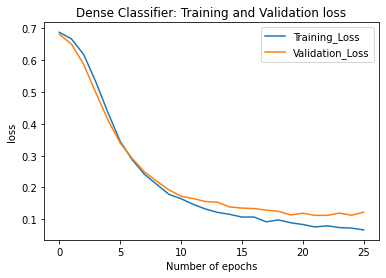

In [33]:
plotGraphs('Training_Loss', 'Validation_Loss', 'loss','Dense Classifier: Training and Validation ',metrics)

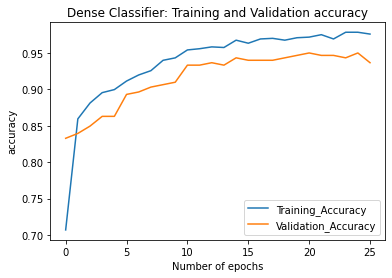

In [34]:
plotGraphs('Training_Accuracy', 'Validation_Accuracy', 'accuracy','Dense Classifier: Training and Validation ',metrics)

In [35]:
#LSTM layer arcitecture hyperparameters
n_lstm = 20
drop_lstm =0.2

In [36]:
#LSTM Spam detection architecture
model1 = Sequential()
model1.add(Embedding(vocab_size, embeding_dim, input_length=max_len))
model1.add(LSTM(n_lstm, dropout=drop_lstm, return_sequences=True))
model1.add(LSTM(n_lstm, dropout=drop_lstm, return_sequences=True))
model1.add(GlobalAveragePooling1D())
model1.add(Dense(1, activation='sigmoid'))


In [37]:
model1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 50, 16)            8000      
                                                                 
 lstm (LSTM)                 (None, 50, 20)            2960      
                                                                 
 lstm_1 (LSTM)               (None, 50, 20)            3280      
                                                                 
 global_average_pooling1d_1   (None, 20)               0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_2 (Dense)             (None, 1)                 21        
                                                                 
Total params: 14,261
Trainable params: 14,261
Non-trainable params: 0
__________________________________________________

In [38]:
model1.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics=['accuracy'])

In [39]:
# Training
num_epochs = 30
early_stop = EarlyStopping(monitor='val_loss', patience=2)
history = model1.fit(training_padded, train_labels, epochs=num_epochs, 
                     validation_data=(testing_padded, test_labels),callbacks =[early_stop], verbose=2)

Epoch 1/30
38/38 - 7s - loss: 0.6693 - accuracy: 0.5967 - val_loss: 0.5557 - val_accuracy: 0.7860 - 7s/epoch - 174ms/step
Epoch 2/30
38/38 - 2s - loss: 0.3782 - accuracy: 0.8845 - val_loss: 0.2548 - val_accuracy: 0.9197 - 2s/epoch - 44ms/step
Epoch 3/30
38/38 - 2s - loss: 0.2207 - accuracy: 0.9406 - val_loss: 0.1902 - val_accuracy: 0.9532 - 2s/epoch - 44ms/step
Epoch 4/30
38/38 - 2s - loss: 0.1618 - accuracy: 0.9598 - val_loss: 0.1619 - val_accuracy: 0.9565 - 2s/epoch - 44ms/step
Epoch 5/30
38/38 - 2s - loss: 0.1227 - accuracy: 0.9682 - val_loss: 0.2272 - val_accuracy: 0.9331 - 2s/epoch - 44ms/step
Epoch 6/30
38/38 - 2s - loss: 0.1056 - accuracy: 0.9715 - val_loss: 0.1740 - val_accuracy: 0.9465 - 2s/epoch - 42ms/step


In [40]:
# Create a dataframe
metrics1 = pd.DataFrame(history.history)

# Rename column
metrics1.rename(columns = {'loss': 'Training_Loss', 'accuracy': 'Training_Accuracy',
                         'val_loss': 'Validation_Loss', 'val_accuracy': 'Validation_Accuracy'}, inplace = True)

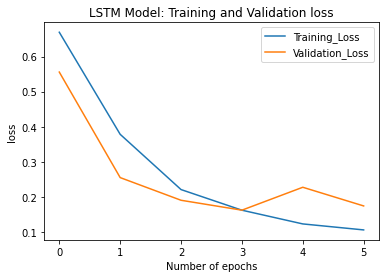

In [41]:
plotGraphs('Training_Loss', 'Validation_Loss', 'loss','LSTM Model: Training and Validation ',metrics1)

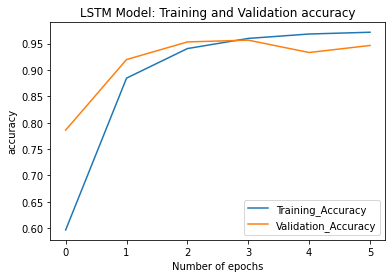

In [42]:
plotGraphs('Training_Accuracy', 'Validation_Accuracy', 'accuracy','LSTM Model: Training and Validation ',metrics1)

In [59]:
# Biderectional LSTM Spam detection architecture
model2 = Sequential()
model2.add(Embedding(vocab_size, embeding_dim, input_length=max_len))
model2.add(Bidirectional(LSTM(n_lstm, dropout=drop_lstm, return_sequences=True)))
model2.add(GlobalAveragePooling1D())

model2.add(Dense(1, activation='sigmoid'))


In [60]:
model2.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics=['accuracy'])

In [61]:
# Training
num_epochs = 40
early_stop = EarlyStopping(monitor='val_loss', patience=2)
history = model2.fit(training_padded, train_labels, epochs=num_epochs, 
                    validation_data=(testing_padded, test_labels),callbacks =[early_stop], verbose=2)

Epoch 1/40
38/38 - 6s - loss: 0.6701 - accuracy: 0.7364 - val_loss: 0.5970 - val_accuracy: 0.7960 - 6s/epoch - 170ms/step
Epoch 2/40
38/38 - 1s - loss: 0.4134 - accuracy: 0.8686 - val_loss: 0.3043 - val_accuracy: 0.8829 - 1s/epoch - 34ms/step
Epoch 3/40
38/38 - 1s - loss: 0.2095 - accuracy: 0.9314 - val_loss: 0.2169 - val_accuracy: 0.9331 - 1s/epoch - 32ms/step
Epoch 4/40
38/38 - 1s - loss: 0.1515 - accuracy: 0.9531 - val_loss: 0.1696 - val_accuracy: 0.9498 - 1s/epoch - 33ms/step
Epoch 5/40
38/38 - 1s - loss: 0.1261 - accuracy: 0.9640 - val_loss: 0.1450 - val_accuracy: 0.9565 - 1s/epoch - 33ms/step
Epoch 6/40
38/38 - 1s - loss: 0.1070 - accuracy: 0.9707 - val_loss: 0.1493 - val_accuracy: 0.9465 - 1s/epoch - 33ms/step
Epoch 7/40
38/38 - 1s - loss: 0.0959 - accuracy: 0.9665 - val_loss: 0.2665 - val_accuracy: 0.9130 - 1s/epoch - 33ms/step


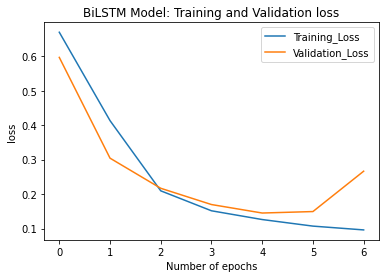

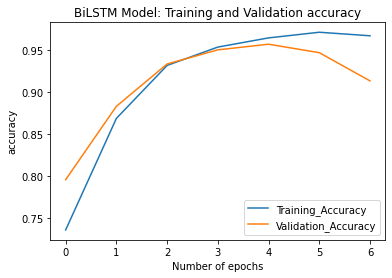

In [62]:
# Create a dataframe
metrics2 = pd.DataFrame(history.history)

# Rename column
metrics2.rename(columns = {'loss': 'Training_Loss', 'accuracy': 'Training_Accuracy',
                         'val_loss': 'Validation_Loss', 'val_accuracy': 'Validation_Accuracy'}, inplace = True)

plotGraphs('Training_Loss', 'Validation_Loss', 'loss','BiLSTM Model: Training and Validation ',metrics2)
plotGraphs('Training_Accuracy', 'Validation_Accuracy', 'accuracy','BiLSTM Model: Training and Validation ',metrics2)

In [63]:
# Comparing three different models
print(f"Dense architecture loss and accuracy: {model.evaluate(testing_padded, test_labels)} " )
print(f"LSTM architecture loss and accuracy: {model1.evaluate(testing_padded, test_labels)} " )
print(f"Bi-LSTM architecture loss and accuracy: {model2.evaluate(testing_padded, test_labels)} " )

10/10 [==============================] - 0s 2ms/step - loss: 0.1224 - accuracy: 0.9365
Dense architecture loss and accuracy: [0.122383713722229, 0.9364548325538635] 
10/10 [==============================] - 0s 11ms/step - loss: 0.1740 - accuracy: 0.9465
LSTM architecture loss and accuracy: [0.17397856712341309, 0.9464883208274841] 
10/10 [==============================] - 0s 11ms/step - loss: 0.2665 - accuracy: 0.9130
Bi-LSTM architecture loss and accuracy: [0.2664792239665985, 0.9130434989929199] 


In [64]:
# Calculating FPR and TPR of all models
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve,roc_auc_score

#fpr, tpr contains falls positive and true positive rate of models

y_pred_model = model.predict(testing_padded).ravel()
fpr, tpr, thresholds = roc_curve(test_labels, y_pred_model)
precision, recall, thresholds = precision_recall_curve(test_labels,y_pred_model)

y_pred_model = model1.predict(testing_padded).ravel()
fpr_1, tpr_1, thresholds_1 = roc_curve(test_labels, y_pred_model)
precision1, recall1, thresholds1 = precision_recall_curve(test_labels,y_pred_model)


y_pred_model = model2.predict(testing_padded).ravel()
fpr_2, tpr_2, thresholds_2 = roc_curve(test_labels, y_pred_model)
precision2, recall2, thresholds2 = precision_recall_curve(test_labels,y_pred_model)

prec, rec, _ = precision_recall_curve(test_labels1,predict)
fpr4, tpr4, _ = roc_curve(test_labels1,predict)


from sklearn.metrics import auc
auc1 = auc(fpr, tpr)
auc2 = auc(fpr_1, tpr_1)
auc3 = auc(fpr_2, tpr_2)
auc4 = roc_auc_score(test_labels1,predict)


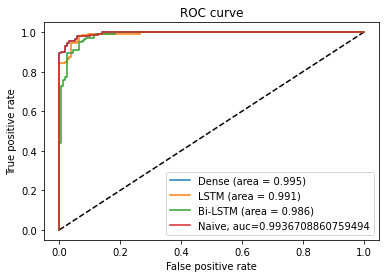

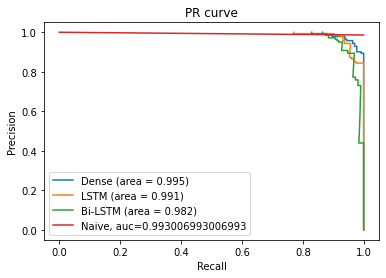

In [65]:
# Generating ROC curves
plt.figure(1)

plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='Dense (area = {:.3f})'.format(auc1))
plt.plot(fpr_1, tpr_1, label='LSTM (area = {:.3f})'.format(auc2))
plt.plot(fpr_2, tpr_2, label='Bi-LSTM (area = {:.3f})'.format(auc3))
plt.plot(fpr,tpr,label="Naive, auc="+str(auc4))

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()


plt.figure(2)

auc1 = auc(recall,precision)
auc2 = auc(recall1,precision1)
auc3 = auc(recall2,precision2)
auc4 =  auc(rec,prec)


plt.plot(precision, recall, label='Dense (area = {:.3f})'.format(auc1))
plt.plot(precision1, recall1, label='LSTM (area = {:.3f})'.format(auc2))
plt.plot(precision2, recall2, label='Bi-LSTM (area = {:.3f})'.format(auc3))
plt.plot(rec,prec,label="Naive, auc="+str(auc4))

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('PR curve')
plt.legend(loc='best')
plt.show()
